In [ ]:
import pandas as pd

#### Загрузить данные в pandas по url=https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv

In [ ]:
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv"
df = pd.read_csv(url, sep = "\t")

#### 1. Вывести: кол-во наблюдений в датасете

In [ ]:
print(len(df))

In [ ]:
print(df)

#### 5. Измените тип переменной item_price c с помощью лямбды функции

 Item_sum = item_price * quantity

In [ ]:
df["item_sum"] = df.apply(lambda x: float(x["item_price"][1:-1]), axis=1) 
df["item_price"] = df.apply(lambda x: float(x["item_sum"])/x["quantity"], axis=1) 

### Создание нового фрейма 

df_modified - содержит все элементы без and

In [ ]:
df_and_only = df[df["item_name"].str.find("and") != -1]
df_modified = df.drop(df_and_only.index).reset_index()
df_modified = df_modified.drop('index', axis=1)
df_chips = df[df["item_name"] == "Chips"].drop_duplicates().head(1)
chips_price = df_chips.item_price.values[0]
df_chips = df_and_only.copy()
df_chips["item_name"] = "Chips"
df_chips["item_price"] = chips_price
df_sause = df_and_only.copy()
df_sause["item_name"] = df_sause.apply(lambda x: x["item_name"][10:], axis=1)
df_sause["item_price"] = df_sause["item_price"] - chips_price
df_and_only = pd.concat([df_chips, df_sause], ignore_index=True)
df_modified = pd.concat([df_modified, df_and_only], ignore_index=True)

#### 2. Вывести названия столбцов

In [ ]:
print(df.columns.values) # df.columns.tolist()

#### 3. Определить самую частую позицию (item) в заказе 

In [ ]:
# unique_df = df.groupby(["order_id", "item_name"]).count().reset_index()
# unique_df = unique_df[unique_df["quantity"] >= 2][["order_id", "item_name","quantity"]]
# correct_df = df.loc[~df["order_id"].isin(unique_df["order_id"])]
# incorrect_df = df.loc[df["order_id"].isin(unique_df["order_id"]), ['item_name', 'choice_description', 'item_price']].drop_duplicates()

In [ ]:
print(df_modified.groupby("item_name").agg({"quantity":"sum"}).sort_values("quantity", ascending=False)) #.head(1).index.values) # либо tolist()

#### 4. Построить гистрограмму частоты заказов по позициям (item )

Ограничимся 10 наиболее часто заказываемыми позициями

In [ ]:
import matplotlib.pyplot as plt

df_hist = df_modified.groupby("item_name", as_index = False).agg({"quantity":"sum"}).sort_values("quantity", ascending=False).head(10)
plt.barh(df_hist.item_name.values, df_hist.quantity.values)
plt.xlabel("Number of orders")

#### 6. Построить гистограмму кол-во денег заработанных по каждой позиции (item)

In [ ]:
df_hist_sum = df_modified.groupby("item_name", as_index = False).agg({"item_sum":"sum"}).sort_values("item_sum", ascending=False).head(10)
plt.barh(df_hist_sum.item_name.values, df_hist_sum.item_sum.values)
plt.xlabel("Sum in dollars")

#### 7. Средняя сумма заказа? (минимум 2 способа)

In [ ]:
print(df.groupby("order_id").agg({"item_sum":"sum"}).mean())
sum = df["item_sum"].sum()
num = len(df["order_id"].unique())
print(sum/num)

#### 8. Выведите среднее, минимальное и максимальное, медианное значения позиций в заказе

In [ ]:
print(df.groupby("order_id").agg({"item_price":["min", "max", "mean", "median"]}))

#### 9. Определить статистику заказов стейков, а также статистику заказов прожарки.

- df_steak - содержит все блюда, содержашие в своем имени слово "Steak". 
- В полях "mild", "medium", "hot" указывается сколько раз упоминалось это слово в "choice description". 
- В поле "list_fire" содержится СПИСОК всех упоминаний "mild", "medium", "hot"

In [ ]:
import re
import numpy as np
dishes_lst = df["item_name"].unique().tolist()
steak_dishes_lst = list(filter(lambda x: x.find("Steak") != -1, dishes_lst))
df_steak = df[df["item_name"].isin(steak_dishes_lst)].reset_index().drop('index', axis=1)
print("Колличество заказов стейков ", df_steak["item_name"].count())
# print(df.loc[df["item_name"].isin(steak_lst)].agg({"order_id":"count", "quantity":"sum"}))
# res = df_steak.loc[df_steak["item_name"].isin(steak_dishes_lst), ["choice_description"]]["choice_description"].unique().tolist()
# for i in res:
#     print(re.findall(r'\((\w+)\)', i))
# (Medium), (Mild), (Hot)


def find_type(x, type):
    res = re.findall(r'\({}\)'.format(type), x["choice_description"])
    return len(res) if res else np.nan

def find_all_types(x):
    res = re.findall(r'\((\w+)\)', x["choice_description"])
    return res if res else np.nan


df_steak['mild'] = df_steak.apply(lambda x: find_type(x, "Mild"), axis=1)
df_steak['medium'] = df_steak.apply(lambda x: find_type(x, "Medium"), axis=1)
df_steak['hot'] = df_steak.apply(lambda x: find_type(x, "Hot"), axis=1)
df_steak = df_steak.astype({'mild': "Int64", 'medium': "Int64", 'hot': "Int64"})
df_steak['list_fire'] = df_steak.apply(lambda x: find_all_types(x), axis=1)
print("Колличество заказов стейков Mild ", df_steak["mild"].count())
print("Колличество заказов стейков Medium ", df_steak["medium"].count())
print("Колличество заказов стейков Hot ", df_steak["hot"].count())

#### 10. Добавить новый столбец цен на каждую позицию в заказе в рублях.

In [ ]:
df["item_price_rub"]= df.apply(lambda x: x["item_price"]*71, axis=1)
print(df)

#### 11. Сгруппировать заказы по входящим позициям в него. Отдельно сгруппировать по стейкам во всех видах прожарках.

In [ ]:
print(df_modified.groupby("item_name").agg({"order_id":"count"}))
print(df_steak.astype('str').groupby(['list_fire']).agg({"order_id":"count"})) #[df_steak.list_fire.notna()]

#### 12. Определить цену по каждой позиции в отдельности. 

In [ ]:
df_unique_item = df_modified.groupby("item_name", as_index=False).agg({"item_price":lambda x: list(set(x.values.tolist()))})
print(df_unique_item)

### Алгоритмы уменьшения размерности 

#### повторить эксперименты в главе 5.1 Qalitative Comparison of Multiple Algorithms статьи статьи UMAP: Uniform Manifold
#### Approximation and Projection for Dimension Reduction (https://arxiv.org/pdf/1802.03426.pdf)

#### необходимо воспроизвести все графики данной главы, соотнести выводы из статьи с вашими результатами.

#### COIL

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [7]:
lst_dir = os.listdir('coil-20-proc')
lst = []
for pic_name in lst_dir:
    image = plt.imread(f'coil-20-proc\{pic_name}', format='png')
    lst.append(image.ravel())

labels_coil = [i for i in range(1, 21) for k in range(72)]
data_coil = np.array(lst)

In [4]:
print(data_coil)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### MNIST

In [5]:
import gzip

def uz_data(file_name, num_images):
    with gzip.open(file_name, 'r') as f:
        image_size = 28
        f.read(16)
        buf = f.read(image_size * image_size * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, image_size*image_size)
    return data
        
def uz_labels(file_name, num_labels):
    with gzip.open(file_name, 'r') as f:
        f.read(8)
        buf = f.read(num_labels)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [8]:
data_mnist = np.concatenate([uz_data('mnist/train-images-idx3-ubyte.gz', 60000), uz_data('mnist/train-images-idx3-ubyte.gz', 10000)], axis=0)
labels_mnist = np.concatenate([uz_labels('mnist/train-labels-idx1-ubyte.gz', 60000), uz_labels('mnist/train-labels-idx1-ubyte.gz', 10000)], axis=0)

In [9]:
print(data_mnist.shape)

(70000, 784)


In [10]:
print(labels_mnist.shape)

(70000,)


#### FashionMNIST

In [11]:
data_fmnist = np.concatenate([uz_data('fmnist/train-images-idx3-ubyte.gz', 60000), uz_data('fmnist/train-images-idx3-ubyte.gz', 10000)], axis=0)
labels_fmnist = np.concatenate([uz_labels('fmnist/train-labels-idx1-ubyte.gz', 60000), uz_labels('fmnist/train-labels-idx1-ubyte.gz', 10000)], axis=0)

#### Google News

In [2]:
from gensim.models import KeyedVectors

google_news_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"

model = KeyedVectors.load_word2vec_format(google_news_path, binary=True)

In [3]:
print(model.vectors.shape)

(3000000, 300)


#### Снижение размерности

##### PCA

In [29]:
pca = PCA(n_components=2)

In [ ]:
data_coil_pca = pca.fit(data_coil).transform(data_coil)

In [27]:
data_mnist_pca = pca.fit(data_mnist).transform(data_mnist)

In [41]:
data_fmnist_pca = pca.fit(data_fmnist).transform(data_fmnist)

##### t-SNE

In [9]:
tsne = TSNE(n_jobs=4)

In [ ]:
data_coil_tsne = tsne.fit_transform(data_coil)

In [ ]:
data_mnist_tsne = tsne.fit_transform(data_mnist)

In [ ]:
data_fmnist_tsne = tsne.fit_transform(data_fmnist)

##### UMAP

In [4]:
umap = UMAP(n_components=2)

In [18]:
data_coil_umap = umap.fit_transform(data_coil)

In [ ]:
data_mnist_umap = umap.fit_transform(data_mnist)

In [ ]:
data_fmnist_umap = umap.fit_transform(data_fmnist)

In [ ]:
data_google_umap = umap.fit_transform(model.vectors)

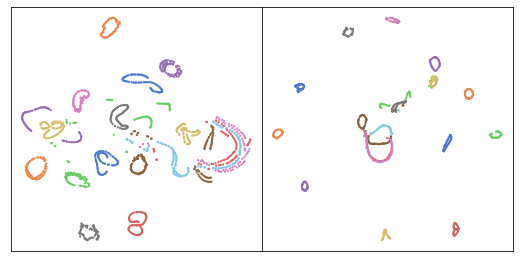

In [22]:
plt.figure(figsize=(18, 18))
# plt.subplot(441)
# sns.scatterplot(x=data_coil_pca[:, 0], y=data_coil_pca[:, 1], hue=labels_coil, palette=sns.color_palette("muted", 20), legend=False, s=10, linewidth=0)
# plt.xticks([])
# plt.yticks([])
# plt.subplot(442)
# sns.scatterplot(x=data_mnist_pca[:, 0], y=data_mnist_pca[:, 1], hue=labels_mnist, palette=sns.color_palette("muted", 10), legend=False, s=5, linewidth=0)
# plt.xticks([])
# plt.yticks([])
# plt.subplot(443)
# sns.scatterplot(x=data_fmnist_pca[:, 0], y=data_fmnist_pca[:, 1], hue=labels_fmnist, palette=sns.color_palette("muted", 10), legend=False, s=6, linewidth=0)
# plt.xticks([])
# plt.yticks([])
plt.subplot(445)
sns.scatterplot(x=data_coil_tsne[:, 0], y=data_coil_tsne[:, 1], hue=labels_coil, palette=sns.color_palette("muted", 20), legend=False, s=5, linewidth=0)
plt.xticks([])
plt.yticks([])
plt.subplot(446)
sns.scatterplot(x=data_coil_umap[:, 0], y=data_coil_umap[:, 1], hue=labels_coil, palette=sns.color_palette("muted", 20), legend=False, s=4, linewidth=0)
plt.xticks([])
plt.yticks([])

plt.subplots_adjust(wspace=0, hspace=0)